Imports

In [1]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow_addons as tfa
import csv

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

/home/harvey/tf-env/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 Super, compute capability 7.5


Load all the tfrecords.

In [2]:
records = []
from os import walk
for (dirpath, dirnames, filenames) in walk("records/"):
    for f in filenames:
        if "train" in f:
            records.append("records/{}".format(f))

print(records)

['records/train10-2071.tfrec', 'records/train12-2071.tfrec', 'records/train11-2071.tfrec', 'records/train06-2071.tfrec', 'records/train03-2071.tfrec', 'records/train02-2071.tfrec', 'records/train05-2071.tfrec', 'records/train13-2071.tfrec', 'records/train01-2071.tfrec', 'records/train15-2061.tfrec', 'records/train14-2071.tfrec', 'records/train07-2071.tfrec', 'records/train00-2071.tfrec', 'records/train08-2071.tfrec', 'records/train04-2071.tfrec', 'records/train09-2071.tfrec']


In [3]:
dataset = tf.data.TFRecordDataset(filenames = records)

In [4]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

Store the amount of images for each patient in patient_image_count.
<br>
Store a mappting of image name -> patient id in image_to_patient

In [5]:
patient_image_count = {}
image_to_patient = {}

with open("train.csv", "r") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    headings = next(reader)
    for im in reader:
        name = im[0]
        patient_id = im[1]
        if patient_id not in patient_image_count:
            patient_image_count[patient_id] = 0
        patient_image_count[patient_id] += 1
        image_to_patient[name] = patient_id
        #print(i, cimages[i]["Target"], ctarget)

In [6]:
IMG_SIZE = 16

longest = max(patient_image_count.values())
print("Longest sequence is: {}".format(longest))

Longest sequence is: 115


Initialize each patient's structure as follows:<br>
In the 'Targets' array we will store a (longest,) numpy array for each patient containing the targets for each image.<br>
In the 'Masks' array we will store a (longest,) numpy array for each patient containing it's mask.<br>
In the 'Images' array we will store a (longest X IMG_SIZE X IMG_SIZE X 3) numpy array for each patient containing the images.<br>
In the 'Written' array we will store an index of how many examples have been written for each patient, This will be useful in the next step.<br>
In the 'Patient_Order' array we will store a mapping of patient_name -> position in other array, This will be useful in the next step.

In [7]:
targets = []
masks = []
images = []

written = []
patient_order = {}

i = 0

for patient in patient_image_count.keys():
    target_arr = np.zeros((longest,))
    mask_arr = np.ones((longest,))
    image_arr = np.zeros((longest, IMG_SIZE, IMG_SIZE, 3))
    
    targets.append(target_arr)
    masks.append(mask_arr)
    images.append(image_arr)
    
    written.append(0)
    patient_order[patient] = i
    i += 1

Iterate over the dataset and do the following for each example:
<br>
Parse it's image and get the images name.<br>
Find out which patient the image is for.<br>
Find out where in the order this patient is.<br>
Find how many images have been written for this patient.<br>
Increment this patients written value.<br>
Write the image to the correct position in this patients image array.<br>
Write the target to the correct position in this patients target array.<br>
Set the mask value to 0 in the correct position in this patients mask array.

In [8]:
for image in dataset:
    # Parse image.
    example = tf.io.parse_single_example(image, feature_description)
    img = tf.io.decode_image(example['image'], expand_animations = False, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Get image name.
    name = example['image_name'].numpy().decode("utf_8")

    # Get image target.
    target = example['target'].numpy()
    
    # Work out which patient this belongs to.
    patient = image_to_patient[name]
    
    # Find out patient's index.
    patient_index = patient_order[patient]
    
    # Find how many images have been written to this patient.
    written_index = written[patient_index]
    
    # Write image.
    images[patient_index][written_index, :, :, :] = img
    
    # Write target.
    targets[patient_index][written_index] = target
    
    # Set mask to 0.
    masks[patient_index][written_index] = 0
    
    # Increment written value.
    written[patient_index] += 1

Split into train/val sets

In [9]:
total = 33126
#for i in iter(alldata):
#    total += 1
#print("{} images in total.".format(total))

In [10]:
train = 0.66
val = 0.33

train_num = int(total*train)
val_num = int(total*val)

In [28]:
train_targets = np.array(targets[0:train_num])
val_targets = np.array(targets[train_num:])

train_masks = np.array(masks[0:train_num])
val_masks = np.array(masks[train_num:])

train_images = np.array(images[0:train_num])
val_images = np.array(images[train_num:])

Define model

In [12]:
def scaled_dot_product_attention(q, k, v, mask):
    # Matrix multiply the querys by the keys
    qk = tf.matmul(q, k, transpose_b=True, name="query*key")
    
    # Get the dimension of the keys and scale the attention by it
    key_dim = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention = tf.cast(qk, tf.float32)/tf.math.sqrt(key_dim)
    
    # Use the mask to set the masked images( The padding ) to a very small number. Softmax will zero these out.
    canceller = mask*-(10**9)
    
    scaled_attention += canceller
    
    # Softmax the attention weights
    attention_weights = tf.nn.softmax(scaled_attention, axis=-1, name="softmax_attention")
    
    # Multiply the values by the weights
    out = tf.matmul(attention_weights, tf.cast(v, tf.float32), name="attention_out")
    
    return out

In [13]:
attention_filters = 32
output_neurons = 1

In [14]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [15]:
def create_attention_net(neurons, name):
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    conv = Conv2D(neurons, kernel_size=(3, 3), strides=(1, 1), activation="relu")(inp)
    maxpool = MaxPool2D(pool_size=(5, 5))(conv)
    flatten = Flatten()(maxpool)
    submodel = tf.keras.Model(name=name, inputs=[inp], outputs=[flatten])
    return submodel

In [25]:
num_images = longest

# Create input for images and masks.
images_in = tf.keras.Input(name="Images_In", shape=(num_images, IMG_SIZE, IMG_SIZE, 3))
mask_in  = tf.keras.Input(name="Mask_In", shape=(num_images,))

# Create ConvNet to compute query, key and value vectors
key_net = create_attention_net(attention_filters, "key_net")
query_net = create_attention_net(attention_filters, "query_net")
value_net = create_attention_net(attention_filters, "value_net")

output_net = Dense(output_neurons, activation="softmax", name="output_net")

keys = []
querys = []
values = []

# Compute querys keys and values for each image
for i in range(num_images):
    image = images_in[:, i, :, :, :]

    keys.append(key_net(image))
    querys.append(query_net(image))
    values.append(value_net(image))

keys = tf.stack(keys, axis=1)
querys = tf.stack(querys, axis=1)
values = tf.stack(values, axis=1)

new_image_vectors = scaled_dot_product_attention(querys, keys, values, mask_in)

outputs = []

for i in range(num_images):
    img_vec = new_image_vectors[:, i, :]
    cout = output_net(img_vec)
    outputs.append(cout)
    
output = tf.stack(outputs, axis=1)
print(output.shape)

model = tf.keras.Model(inputs=[images_in, mask_in], outputs=output)

(None, 115, 1)


Precision - 
How many of the melanoma that we said are bad were actually bad?
Recall -
How many of the bad melanoma did we catch?

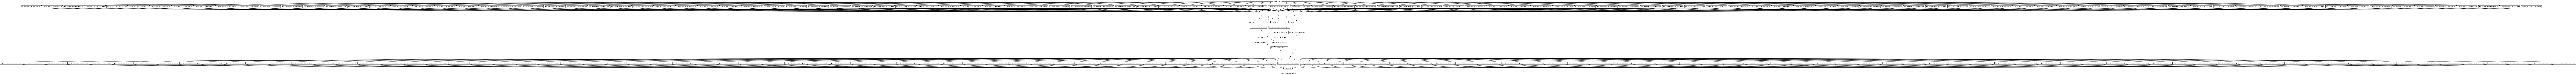

In [17]:
tf.keras.utils.plot_model(model)

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=["AUC"])

In [ ]:
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc",
    patience=3,
    verbose=1,
    mode="max",
    restore_best_weights=True
)

hist = model.fit([train_images, train_masks], train_targets, validation_data=([val_images, val_masks], val_targets),epochs=100, callbacks=[stopper], batch_size=1)

Epoch 1/100
2056/2056 [==============================] - 89s 43ms/step - loss: 15.9058 - auc: 0.5000
Epoch 2/100
2056/2056 [==============================] - 89s 43ms/step - loss: 15.9058 - auc: 0.5000
Epoch 3/100
1886/2056 [==========================>...] - ETA: 7s - loss: 15.9067 - auc: 0.5000

In [ ]:
test_records = []

for (dirpath, dirnames, filenames) in walk("records/"):
    for f in filenames:
        if "test" in f:
            test_records.append("records/{}".format(f))

print(test_records)

In [ ]:
feature_description_test = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string)
}

In [ ]:
test_dataset = tf.data.TFRecordDataset(filenames = test_records)

In [ ]:
test_names = []

for inp in test_dataset:
    example = tf.io.parse_single_example(inp, feature_description_test)
    test_names.append(example['image_name'].numpy().decode("utf_8"))

In [ ]:
test_names[0]

In [ ]:
@tf.function
def toInput(inp):
    example = tf.io.parse_single_example(inp, feature_description_test)
        
    img = tf.io.decode_image(example['image'], expand_animations = False, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    return img

In [ ]:
test_batches = test_dataset.map(toInput)

In [ ]:
test_batches = test_batches.batch(BATCH_SIZE)

In [ ]:
predictions = model.predict(test_batches)

In [ ]:
import csv

i = 0

with open("submission.csv", "w") as csvfile:
    writer = csv.writer(csvfile, delimiter=",")
    writer.writerow(["image_name", "target"])
    for p in predictions:
        prounded = f"{p[0]:.9f}"
        writer.writerow([test_names[i], prounded])
        i += 1